Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.

We will first work towards answering the following question:

*1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import datetime
import json

In [2]:
df = pd.read_json('C:\\Users\\19713\\Desktop\\Springboard\\ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.shape

(50000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We notice that out of the 12 columns, 3 have null values: avg_rating_of_driver, phone, and avg_rating_by_driver. Phone and avg_rating_by_driver are only missing a few hundred values, whereas avg_rating_of_driver is missing more than 8000 values.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00


Let's check the fraction of drivers who were retained.

In [6]:
df['last_trip_date']

0        2014-06-17
1        2014-05-05
2        2014-01-07
3        2014-06-29
4        2014-03-15
            ...    
49995    2014-06-05
49996    2014-01-25
49997    2014-05-22
49998    2014-01-15
49999    2014-04-20
Name: last_trip_date, Length: 50000, dtype: object

We see that even though the values in this column are object, they should be datetime objects instead. We need to convert these strings to date format.

In [7]:
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['last_trip_date']

0       2014-06-17
1       2014-05-05
2       2014-01-07
3       2014-06-29
4       2014-03-15
           ...    
49995   2014-06-05
49996   2014-01-25
49997   2014-05-22
49998   2014-01-15
49999   2014-04-20
Name: last_trip_date, Length: 50000, dtype: datetime64[ns]

In [8]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  object        
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(6), int

We will also need to convert signup_date to a datetime object as well.

In [10]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['signup_date']

0       2014-01-25
1       2014-01-29
2       2014-01-06
3       2014-01-10
4       2014-01-27
           ...    
49995   2014-01-25
49996   2014-01-24
49997   2014-01-31
49998   2014-01-14
49999   2014-01-18
Name: signup_date, Length: 50000, dtype: datetime64[ns]

In [11]:
df['last_trip_date'].describe()

C:\Users\19713\AppData\Local\Temp\ipykernel_14852\632557333.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['last_trip_date'].describe()


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Since we consider a user retained if they were active in the 30 days priors to the very last "last_trip_date," and this occured on July 1st at midnight, to find the fraction of users who were retained, we will be checking the fraction of users who were active in June (since June as 30 days).

In [12]:
fraction_retained = (df['last_trip_date'] >= '2014-06-01').sum() / (df['last_trip_date']).count()
fraction_retained

0.37608

37.608% of users were retained.

Let's now create a column called "was_retained" based on our finding. This column will be our target variable for the modelling part of this project.

In [13]:
df['was_retained'] = (df['last_trip_date'] >= '2014-06-01')*1
df['was_retained']

0        1
1        0
2        0
3        1
4        0
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: was_retained, Length: 50000, dtype: int32

In [14]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,was_retained
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


Now we will proceed with some EDA showing relationships between our features and the target variable "was_retained."

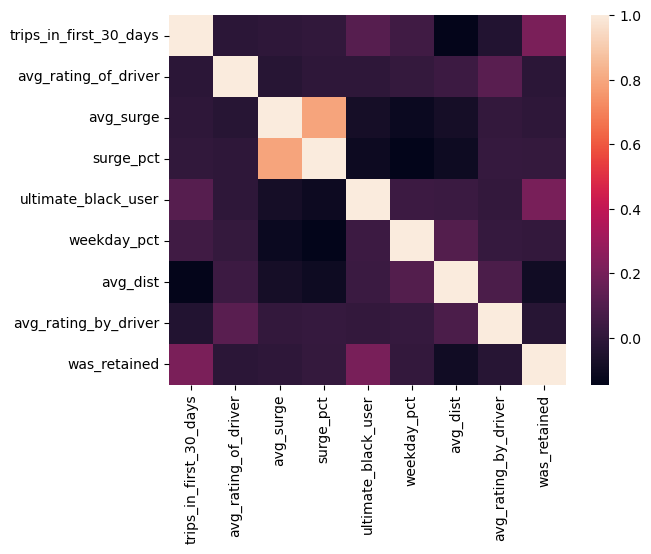

In [15]:
fig = plt.figure()
ax = plt.subplot(111)
corr = df.corr()
ax = sns.heatmap(corr)
plt.show()

In [16]:
corr['was_retained'].sort_values(ascending = False)

was_retained              1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: was_retained, dtype: float64

We see that whether a user was retained or not is somewhat correlated with the number of trips the user took in their first 30 days and whether or not they are an Ultimate Black user. Besides that, there is not much correlation nor anti-correlation with the other features.

We have yet to analyze the relationship between was_retained and our non-numeric columns: city, phone, and the two date columns. Let's do that here.

In [17]:
df['city'].value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [18]:
df['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Both columns have string values. The best way to handle these 2 columns is to one-hot-encode them. There is no need to worry about the dimensionality increasing substantially as both columns have so few values. Before we may proceed however, we must fill in the null values for the phone column so that we can one-hot-encode them properly in scikit-learn when we need to.

In [19]:
df[df['phone'].isnull()].value_counts()

Series([], dtype: int64)

In [20]:
df['phone'].fillna('Other', inplace = True)
df['phone'].value_counts()

iPhone     34582
Android    15022
Other        396
Name: phone, dtype: int64

We have replaced "None" with "Other." Now it is time to one-hot-encode these variables.

In [21]:
cities_ohe = pd.get_dummies(df['city'])
phones_ohe = pd.get_dummies(df['phone'])
df = df.join(cities_ohe).join(phones_ohe)

In [22]:
df.drop(['city', 'phone'], axis = 1, inplace = True)

In [23]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,was_retained,Astapor,King's Landing,Winterfell,Android,Other,iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,0,1,0,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,0,1,0,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,0,1,1,0,0


In [24]:
# move 'was_retained' to the end
col_at_end = ['was_retained']
df = df[[c for c in df if c not in col_at_end] + [c for c in col_at_end]]

In [25]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone,was_retained
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,0,1,0,0,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,0,1,0,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0,0


In [26]:
df.describe().iloc[:,-7:-1]

,Astapor,King's Landing,Winterfell,Android,Other,iPhone
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640
std,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We see that about 33% of users are from Astapor, 20% are from King's Landing, and the rest are from Winterfell. About 30% of users us an Android, about 70% use an iphone, and a very minsucule percentage of user do not use either.

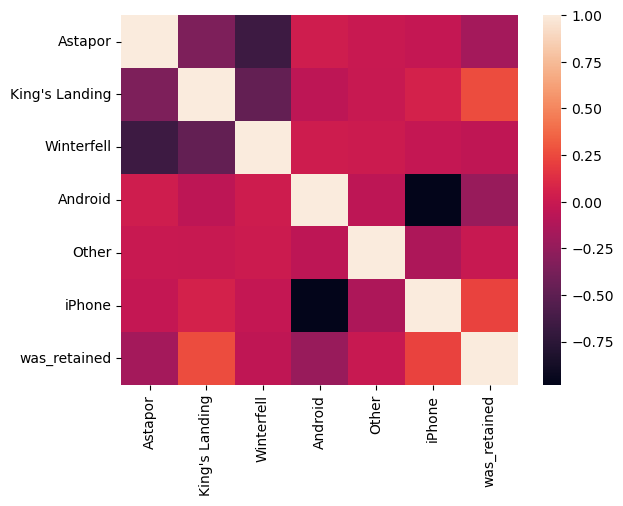

In [27]:
categoricals = df.iloc[:,-7:]
fig = plt.figure()
ax = plt.subplot(111)
corr = categoricals.corr()
ax = sns.heatmap(corr)
plt.show()

In [28]:
corr['was_retained'].sort_values(ascending = False)

was_retained      1.000000
King's Landing    0.262284
iPhone            0.225244
Other            -0.007419
Winterfell       -0.046611
Astapor          -0.174655
Android          -0.225464
Name: was_retained, dtype: float64

We see that being from King's landing and having an iPhone are associated with being retained. On the contrary, being from Astapor and having an Android are negatively associated with retention.

With regard to the 2 date columns, in order to see analyze their correlation with retention, we will first need to encode them numerically. Obviously, we expect last_trip_date to have a high correlation with retention since the retention column was created from last_trip_date. In the actual model, we will remove last_trip_date in order to prevent it from giving us an artificially good performance.

In [29]:
df['signup_date'].describe()

C:\Users\19713\AppData\Local\Temp\ipykernel_14852\3414994839.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['signup_date'].describe()


count                   50000
unique                     31
top       2014-01-18 00:00:00
freq                     2948
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

In [30]:
df['last_trip_date'].describe()

C:\Users\19713\AppData\Local\Temp\ipykernel_14852\632557333.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df['last_trip_date'].describe()


count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

In [31]:
# this will convert the 'signup_date' to a column representing the number of
# days since the beginning of the year when they signed up
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100

In [32]:
df['signup_date']

0        25
1        29
2         6
3        10
4        27
         ..
49995    25
49996    24
49997    31
49998    14
49999    18
Name: signup_date, Length: 50000, dtype: int32

In [33]:
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone,was_retained
0,4,25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,0,1,0,0,0,1,1
1,0,29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,1,0,0,1,0,0,0
2,3,6,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,1,0,0,0,0,1,0
3,9,10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,0,1,0,0,0,1,1
4,14,27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,0,1,1,0,0,0


In [34]:
# check the correlation between signup_date and was_retained
df['signup_date'].corr(df['was_retained'])

-0.02021061843484832

It turns out that signup_date is not very correlated with retention. What about last_trip_date?

In [35]:
ref = min(df['last_trip_date'])
df['last_trip_date'] = (df['last_trip_date'] - ref).dt.days + 1
# We add 1 because this takes the number of days since the first day, not 
# since the last day of the previous year

In [36]:
df['last_trip_date']

0        168
1        125
2          7
3        180
4         74
        ... 
49995    156
49996     25
49997    142
49998     15
49999    110
Name: last_trip_date, Length: 50000, dtype: int64

In [37]:
# check the correlation between last_trip_date and was_retained
df['last_trip_date'].corr(df['was_retained'])

0.7808374961937277

The two variable have very high correlation, as expected.

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   signup_date             50000 non-null  int32  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   last_trip_date          50000 non-null  int64  
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  Astapor                 50000 non-null  uint8  
 11  King's Landing          50000 non-null  uint8  
 12  Winterfell              50000 non-null  uint8  
 13  Android                 50000 non-null  uint8  
 14  Other                   50000 non-null

Let's convert the ultimate_black_user column to int so it shows up with the describe method.

In [39]:
df['ultimate_black_user'] = df['ultimate_black_user']*1

In [40]:
df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,Other,iPhone,was_retained
count,50000.000000,50000.00000,41878.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,49799.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,16.54468,4.601559,1.074764,109.334780,8.849536,0.37708,60.926084,5.796827,4.778158,0.330680,0.202600,0.466720,0.300440,0.007920,0.691640,0.376080
std,3.792684,8.75422,0.617338,0.222336,61.718985,19.958811,0.48466,37.081503,5.707357,0.446652,0.470463,0.401941,0.498896,0.458454,0.088642,0.461821,0.484405
min,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9.00000,4.300000,1.000000,45.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,17.00000,4.900000,1.000000,128.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.000000,24.00000,5.000000,1.050000,169.000000,8.600000,1.00000,100.000000,6.940000,5.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,125.000000,31.00000,5.000000,8.000000,182.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


So far, we have examined the relationship between every feature and our created target column 'was_retained.' To handle the 'city' and 'phone' categorical columns, we needed to one-hot-encode the features first. To handle the date columns, we simply converted those colulmns to the number of days into 2014. Furthermore, since all of our features are numeric now, we can commence the modelling stage.

**----------------------------------------------------------------------------------------------------------------------------------**

*2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.*

These are the steps involved in classification in Scikit-Learn:

1. Preprocess Data
2. Create Train and Test Sets
3. Instantiate the model/estimator
    (Steps 1 and 3 can be combined in a Pipeline object)
4. Specify Hyperparameter Space
5. Instantiate GridSearchCV or RandomizedSearchCV objects
6. Fit CV object to the Training Set
7. Predict on the Test Set
8. Compute Scores for the Model

The following models we will use are:

1. Logistic Regression (LR)
2. K-Nearest Neighbor (KNN)
3. Support Vector Machine (SVM)
4. Decision Trees (DT)
5. Random Forest (RF)
6. Naive Bayes (NB)

We will begin by importing the following tools from sklearn.

In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
import time

In keeping with best practice, let's create all of the models using sklearn's Pipeline object. We will repull the data to do this.

In [42]:
with open('C:\\Users\\19713\\Desktop\\Springboard\\ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

df['was_retained'] = (df.last_trip_date >= '2014-06-01')*1
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
df['last_trip_date'] = (df['last_trip_date'] - min(df['last_trip_date'])).dt.days + 1

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  int32  
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  int64  
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
 12  was_retained            50000 non-null  int32  
dtypes: bool(1), float64(6), int32(2), int64(2), object(2)
memory usage: 4.2+ MB


We will train our classifier with the following features:
1. Categorical Features:
    A. city
    B. phone
2. Numeric Features: Every other feature

We create the preprocessing pipelines for both numeric and categorical data.

In [44]:
#### Step 1) Preprocess Data

np.random.seed(0)

df['phone'].fillna('Other', inplace=True)
categorical_features = ['city', 'phone']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder())
]
)

numeric_features = [column for column in df.columns.tolist() if column not in categorical_features and
                    column not in ['last_trip_date', 'was_retained']]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
]
)

In [45]:
#### Step 2) Split Data into Training and Test Sets
X = df.drop(['was_retained', 'last_trip_date'], axis=1)
y = df['was_retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

Let's create a dataframe which will store the different scoring metrics used to evaluate the performances of our models.

In [46]:
metrics = pd.DataFrame(index=['accuracy', 'precision', 'recall', 'AUC', 'Time to Train', 'f1-score'], 
                       columns=['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Naive Bayes'])

In [47]:
metrics

,Dummy Model,Logistic Regression,K Nearest Neighbors,Decision Tree,Random Forest,Naive Bayes
accuracy,NaN,NaN,NaN,NaN,NaN,NaN
precision,NaN,NaN,NaN,NaN,NaN,NaN
recall,NaN,NaN,NaN,NaN,NaN,NaN
AUC,NaN,NaN,NaN,NaN,NaN,NaN
Time to Train,NaN,NaN,NaN,NaN,NaN,NaN
f1-score,NaN,NaN,NaN,NaN,NaN,NaN


Here we will define a useful function to train and score our models.

In [48]:
# Steps 5 - 8:
def train_and_score_model(model_name, estimator, param_grid=None, cv=5):
    
    #### Step 5: Instantiate the CV Object
    
    if model_name in ['Dummy Model', 'Naive Bayes']:
        cv = estimator
    elif model_name == 'Logistic Regression':
        cv = GridSearchCV(estimator, param_grid, cv=cv)
    else: 
        cv = RandomizedSearchCV(estimator, param_grid, cv=cv, random_state=None)

    #### Step 6: Fit on Training
    t0 = time.time()
    cv.fit(X_train, y_train)
    ttt = time.time() - t0 # ttt stands for "time to train"
    print("It takes %.3f seconds for %s fitting" % (ttt, model_name))
    metrics.loc['Time to Train', model_name] = ttt

    #### Step 7: Predict on Test

    y_pred = cv.predict(X_test)

    #### Step 8: Scoring
    ##### Accuracy

    print("Accuracy with " + model_name + " on the testing set is: %.3f" % cv.score(X_test, y_test))

    metrics.loc['accuracy', model_name] = accuracy_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['precision', model_name] = precision_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['recall', model_name] = recall_score(y_pred=y_pred, y_true=y_test)
    metrics.loc['f1-score', model_name] = f1_score(y_pred=y_pred, y_true=y_test)
    
    y_pred_prob = cv.predict_proba(X_test)[:,1]
    metrics.loc['AUC', model_name] = roc_auc_score(y_test, y_pred_prob)

    print(Conf_Matrix(confusion_matrix(y_test, y_pred)))
    print(classification_report(y_test, y_pred))

    
    # ROC Curve
    fpr, tpr, thresholds  = roc_curve(y_test, y_pred_prob)
    plt.plot([0,1], [0,1], 'k--')
    plt.plot(fpr, tpr, label=model_name)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s ROC Curve' % model_name)
    plt.show()

    return cv

In [49]:
def Conf_Matrix(CM, labels=['Not Retained', 'Retained']):
    df = pd.DataFrame(data=CM, index=labels, columns=labels)
    df.index.name = 'TRUE'
    df.columns.name = 'PREDICTION'
    df.loc['Total'] = df.sum()
    df['Total'] = df.sum(axis=1)
    return df

In [50]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import randint


# Step 3: Instantiate the model/estimator
classifier_dm = DummyClassifier(strategy="most_frequent", random_state=0)
classifier_lr = LogisticRegression(solver='liblinear', random_state=0)
classifier_knn = KNeighborsClassifier()
classifier_dt = DecisionTreeClassifier(random_state=0)
classifier_rf = RandomForestClassifier(random_state=0)
classifier_nb = GaussianNB()

classifiers = [classifier_dm, classifier_lr, classifier_knn, classifier_dt, classifier_rf, classifier_nb]

# Step 4: Specify the Hyperparameter Space
param_grid_dm = None
param_grid_lr = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__C': np.logspace(-5, 8, 15),
    'classifier__penalty': ['l1', 'l2']
}
param_grid_knn = {
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
    'classifier__n_neighbors': np.arange(1,20)
}

param_grid_dt = {
                'preprocessor__num__imputer__strategy': ['mean', 'median'],
                'classifier__max_depth': [3, 10, 20, None],
                'classifier__max_features': randint(1, 9),
                'classifier__min_samples_leaf': randint(1, 9),
                'classifier__min_samples_split': randint(2, 9),
                'classifier__criterion': ["gini", "entropy"]
}
param_grid_rf = {
                 'preprocessor__num__imputer__strategy': ['mean', 'median'], 
                 'classifier__n_estimators': [50, 100],
                 'classifier__criterion': ["gini", "entropy"],
                 'classifier__max_depth': [3, 10, 20, None],
                 'classifier__min_samples_leaf': randint(1, 9),
                 'classifier__min_samples_split': randint(2, 9),
                 'classifier__max_features': randint(1, 9)
}
param_grid_nb = None

param_grids = [param_grid_dm, param_grid_lr, param_grid_knn, param_grid_dt, param_grid_rf, param_grid_nb]

model_names = ['Dummy Model', 'Logistic Regression', 'K Nearest Neighbors', 'Decision Tree', 'Random Forest', 'Naive Bayes']
cv_names = ['dm_cv', 'lr_cv', 'knn_cv', 'dt_cv', 'rf_cv', 'nb_cv']
cvs = [None, 5, 5, 5, 5, 5, 5]

We append the classifier to the preprocesesing pipeline. This will then give us a full prediction pipeline.

In [51]:
import warnings
warnings.filterwarnings("ignore")

It takes 0.200 seconds for Dummy Model fitting
Accuracy with Dummy Modelon the testing set is: 0.624
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          9359         0   9359
Retained              5641         0   5641
Total                15000         0  15000
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      9359
           1       0.00      0.00      0.00      5641

    accuracy                           0.62     15000
   macro avg       0.31      0.50      0.38     15000
weighted avg       0.39      0.62      0.48     15000



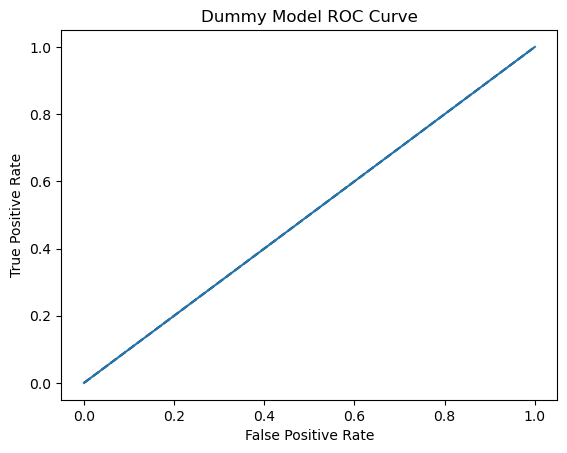

In [52]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                 ('classifier', classifier_dm)])
dm_cv = train_and_score_model('Dummy Model', pipeline, param_grid_dm)

It takes 69.793 seconds for Logistic Regression fitting
Accuracy with Logistic Regressionon the testing set is: 0.716
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7984      1375   9359
Retained              2880      2761   5641
Total                10864      4136  15000
              precision    recall  f1-score   support

           0       0.73      0.85      0.79      9359
           1       0.67      0.49      0.56      5641

    accuracy                           0.72     15000
   macro avg       0.70      0.67      0.68     15000
weighted avg       0.71      0.72      0.71     15000



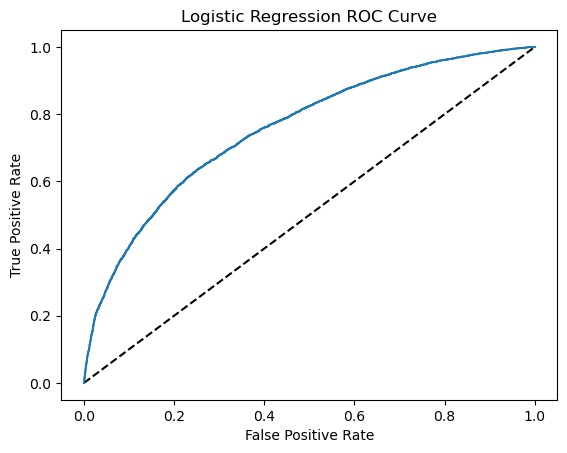

In [53]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_lr)])
lr_cv = train_and_score_model('Logistic Regression', pipeline, param_grid_lr)

It takes 95.549 seconds for K Nearest Neighbors fitting
Accuracy with K Nearest Neighborson the testing set is: 0.750
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7739      1620   9359
Retained              2125      3516   5641
Total                 9864      5136  15000
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      9359
           1       0.68      0.62      0.65      5641

    accuracy                           0.75     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.75      0.75      0.75     15000



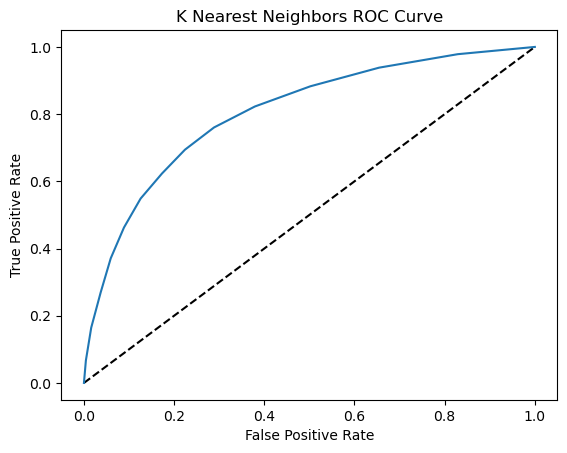

In [54]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_knn)])
knn_cv = train_and_score_model('K Nearest Neighbors', pipeline, param_grid_knn)

It takes 11.255 seconds for Decision Tree fitting
Accuracy with Decision Treeon the testing set is: 0.765
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          7832      1527   9359
Retained              2000      3641   5641
Total                 9832      5168  15000
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      9359
           1       0.70      0.65      0.67      5641

    accuracy                           0.76     15000
   macro avg       0.75      0.74      0.74     15000
weighted avg       0.76      0.76      0.76     15000



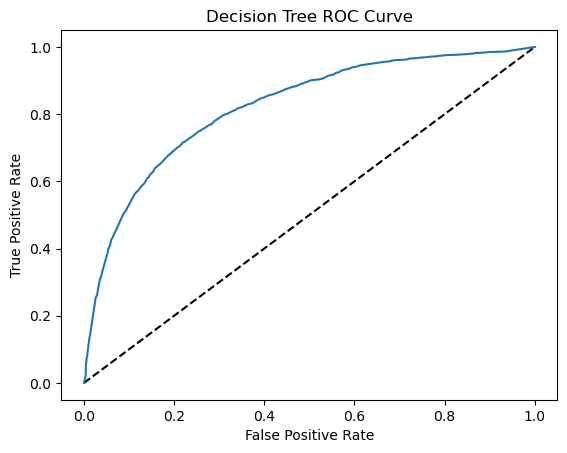

In [55]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_dt)])
dt_cv = train_and_score_model('Decision Tree', pipeline, param_grid_dt)


It takes 129.242 seconds for Random Forest fitting
Accuracy with Random Foreston the testing set is: 0.779
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8036      1323   9359
Retained              1987      3654   5641
Total                10023      4977  15000
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9359
           1       0.73      0.65      0.69      5641

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.78      0.78      0.78     15000



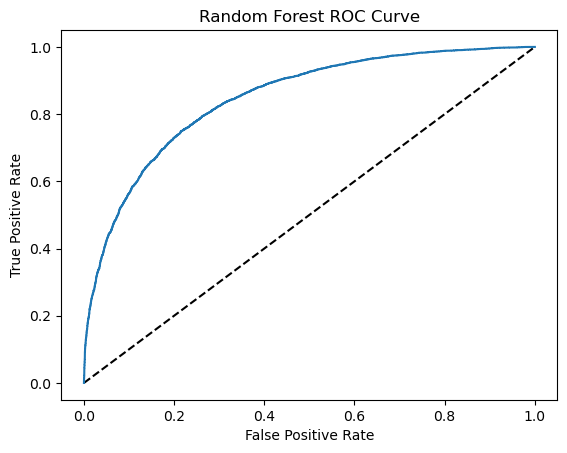

In [56]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_rf)])
rf_cv = train_and_score_model('Random Forest', pipeline, param_grid_rf)

It takes 0.213 seconds for Naive Bayes fitting
Accuracy with Naive Bayeson the testing set is: 0.692
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          6419      2940   9359
Retained              1678      3963   5641
Total                 8097      6903  15000
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      9359
           1       0.57      0.70      0.63      5641

    accuracy                           0.69     15000
   macro avg       0.68      0.69      0.68     15000
weighted avg       0.71      0.69      0.70     15000



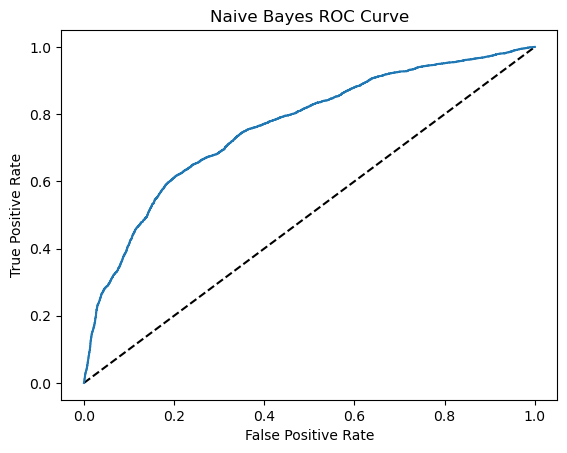

In [57]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                     ('classifier', classifier_nb)])
nb_cv = train_and_score_model('Naive Bayes', pipeline, param_grid_nb)

In [58]:
from pandas.plotting import table
actual_metrics = metrics.astype(float).round(3).loc[['accuracy', 'precision', 'recall', 'AUC', 'f1-score']]*100
actual_metrics

,Dummy Model,Logistic Regression,K Nearest Neighbors,Decision Tree,Random Forest,Naive Bayes
accuracy,62.4,71.6,75.0,76.5,77.9,69.2
precision,0.0,66.8,68.5,70.5,73.4,57.4
recall,0.0,48.9,62.3,64.5,64.8,70.3
AUC,50.0,75.7,80.4,82.1,84.7,76.1
f1-score,0.0,56.5,65.3,67.4,68.8,63.2


Now that we have all the metrics of our models, let's plot these results to get a better picture of how they performed.

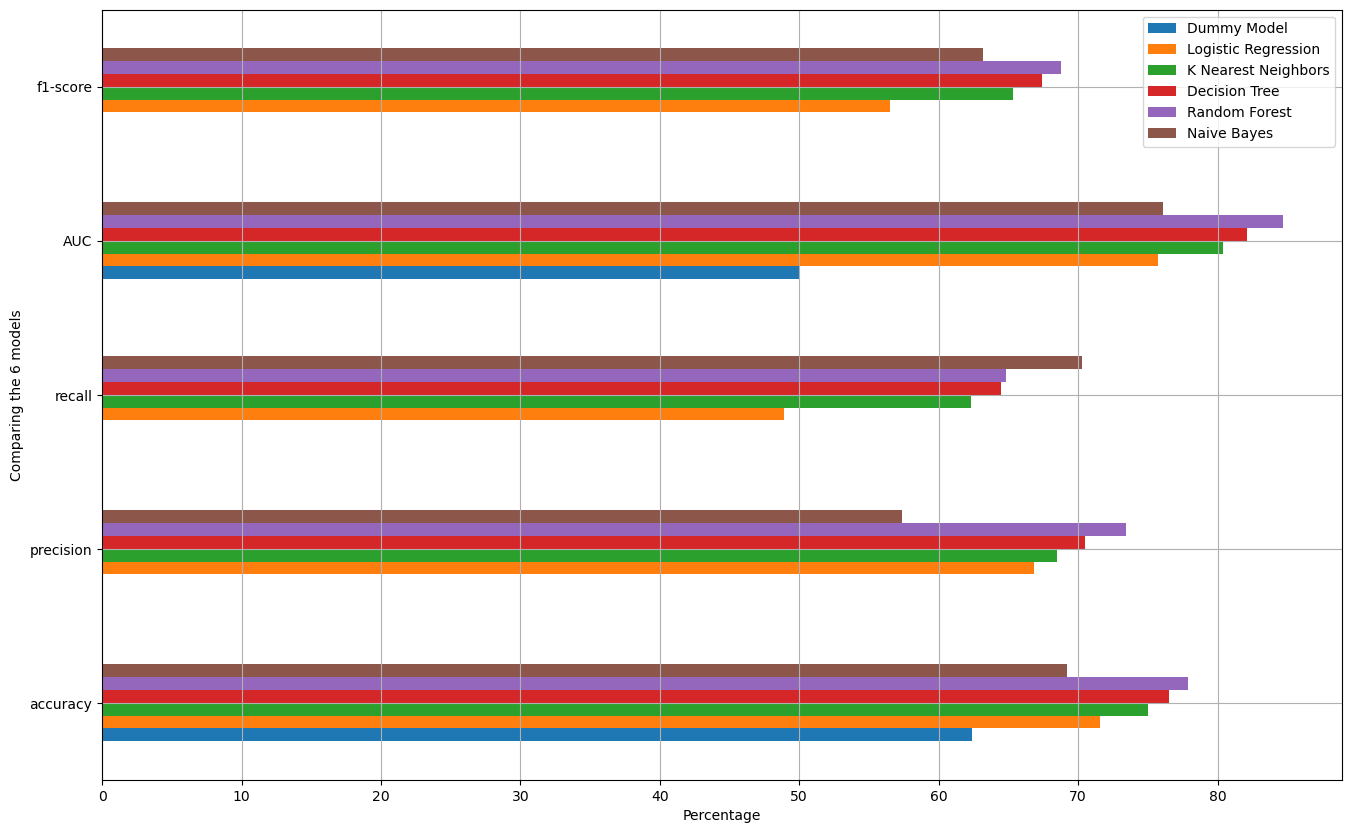

In [59]:
fig, ax = plt.subplots(figsize = (16,10))
actual_metrics.plot(kind = 'barh', ax = ax)
ax.set_xlabel('Percentage')
ax.set_ylabel('Comparing the 6 models')
ax.grid();

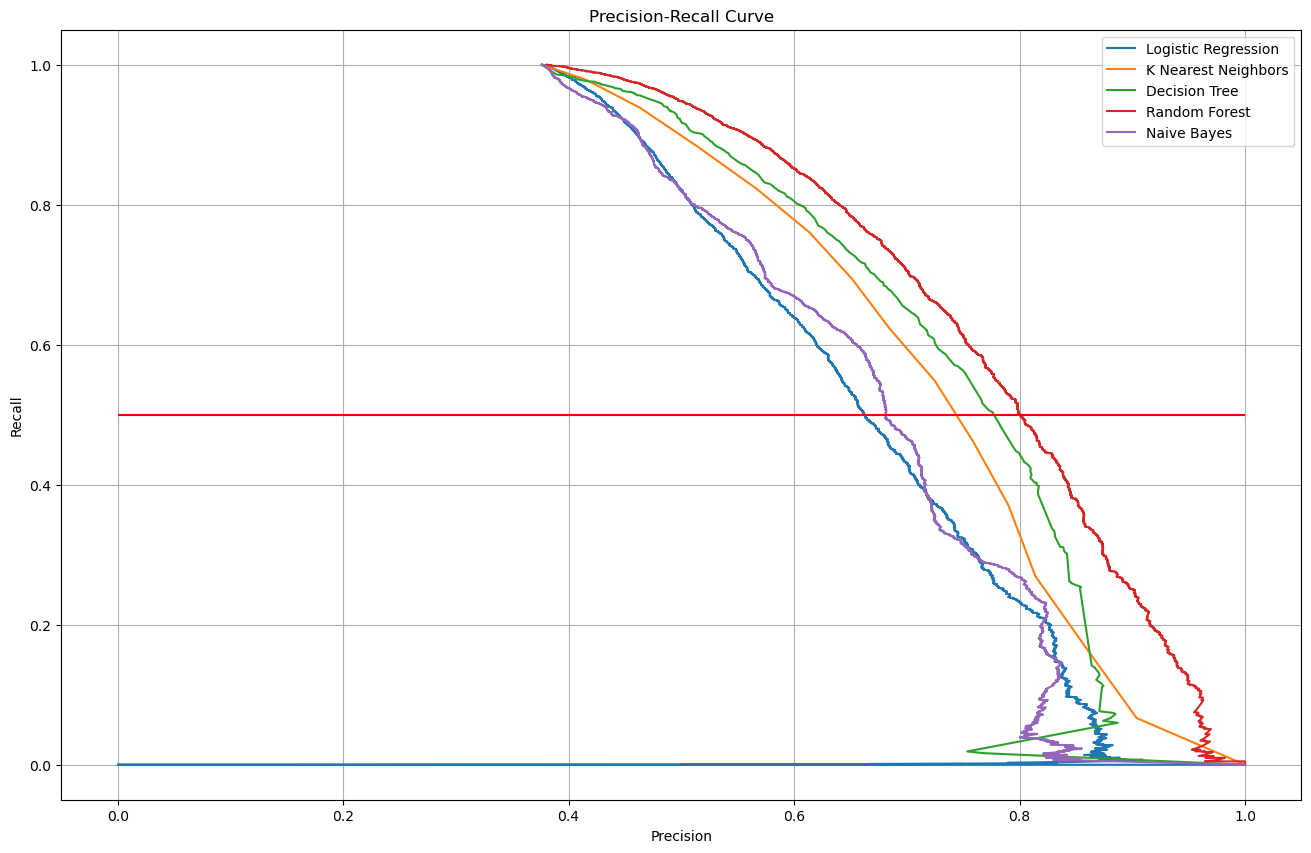

In [60]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_true = y_test, probas_pred = lr_cv.predict_proba(X_test)[:,1])
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_true = y_test, probas_pred = knn_cv.predict_proba(X_test)[:,1])
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_true = y_test, probas_pred = dt_cv.predict_proba(X_test)[:,1])
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_true = y_test, probas_pred = rf_cv.predict_proba(X_test)[:,1])
precision_nb, recall_nb, thresholds_nb = precision_recall_curve(y_true = y_test, probas_pred = nb_cv.predict_proba(X_test)[:,1])

# plot precision vs. recall for the above 5 models

fig, ax = plt.subplots(figsize = (16,10))
ax.plot(precision_lr, recall_lr, label = 'Logistic Regression')
ax.plot(precision_knn, recall_knn, label = 'K Nearest Neighbors')
ax.plot(precision_dt, recall_dt, label = 'Decision Tree')
ax.plot(precision_rf, recall_rf, label = 'Random Forest')
ax.plot(precision_nb, recall_nb, label = 'Naive Bayes')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_title('Precision-Recall Curve')
ax.hlines(y=0.5, xmin = 0, xmax = 1, color = 'red')
ax.legend()
ax.grid();

We see that Random Forest is our best model, with an accuracy of about 78%. This is 15.5% better than the Dummy Model which just predicts that the user was not retained for every user (since there were more non-retained users than retained users), which is a considerable improvement. In addition to having the highest accuracy of any model, we also see that it has the best AUC score of any model. The **Area Under the Curve (AUC)** is the measure of the ability of a binary classifier to distinguish between classes. Since Random Forest has an AUC score of 0.847, this means that it can correctly classify whether a user is retained or not 84.7% of the time. Furthermore, since precision and recall are accounted for in the AUC score, there is not much of a need to further examine the precision and recall scores of each model. Thus, we can definitively say that Random Forest is the best model of the 5 we constructed.

Note that we are able to achieve better or worse results for accuracy, precision, and recall by varying the probability at which we classify retention. By default, the probability threshold is set at 50%, as this is the intuitive level for classification. If we cared more about recall, for example, then we would lower the threshold for classification, as this would classify more of the customers as retained and who were also actually retained customers. However, this would come at the price of precision, as it would then classify some customers as retained even though they were really not a retained customer. Conversely, if we cared more about precision, we would raise the probability threshold, ensuring that we only classified customers as retained if they were really retained. 

Within the context of this scenario, in order to determine which one we care more about maximizing, we have to ask ourselves which of the following cases do we want to avoid more: predicting that a retained customer will not be retained (false negatives), or predicting that a non-retained customer will be retained (false positives)? Since it is not clear which situation we want to avoid more, we will abstain from adjusting the probability threshold. Let's recap the question that we were trying to answer and what we have done to answer it.

*2. Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.*

We built several classification models with the aim of predicting whether or not a user will be active in their 6th month on the system. We decided to go with the Random Forest model to make the predictions since it had the best accuracy and AUC score of all the models we developed. 

In regards to any concerns we may have, the biggest concern would have to do with whether or not we value avoiding false positives or false negatives more. Choosing one of these two options would implicate how we would change the probability threshold to either raise the recall or precision score, whichever suits our needs. In any case, Random Forest still remains as the best model due to it having the best precision-recall curve of any model. 

In terms of model validity, our model is only as accurate as our input data. Furthermore, our model is as only as effective to the degree in which we know how to utilize it well. This goes back to the point made earlier about deciding whether to increase recall or precision. First, we would have to know which of these two goals we would want to accomplish in order to use our model in an optimal manner. 

Finally, to reiterate the indicators of our model performance, we achieved an accuracy of about 78% and an AUC score of about 84.7%. 

*3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long term rider retention (again, a few sentences will suffice).*

In order to leverage any insights gained from the model, we have to take a look at what the Random Forest model considered to be the most important features and try to draw any actionable insights from that. There is a slight problem however. Scikit-learn does not allow us to extract features from a pipeline object, so we do not have a way of observing which feature importances correspond to which features. Therefore, we will need to run our model again using the optimal parameters that we have already found. 

In [61]:
rf_cv.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': 3,
 'classifier__min_samples_leaf': 7,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 50,
 'preprocessor__num__imputer__strategy': 'median'}

In [62]:
rf_model = rf_cv.best_estimator_

In [63]:
rf_model.named_steps['classifier'].feature_importances_

array([0.07154114, 0.07199194, 0.05093047, 0.06473784, 0.09288438,
       0.05062047, 0.14281036, 0.10772827, 0.13506786, 0.02715218,
       0.08739985, 0.02072585, 0.04104392, 0.00042388, 0.03494159])

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  int32  
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  int64  
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
 12  was_retained            50000 non-null  int32  
dtypes: bool(1), float64(6), int32(2), int64(2), object(2)
memory usage: 4.2+ MB


In [65]:
df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,was_retained
count,50000.000000,50000.00000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000.000000
mean,2.278200,16.54468,4.601559,1.074764,109.334780,8.849536,60.926084,5.796827,4.778158,0.376080
std,3.792684,8.75422,0.617338,0.222336,61.718985,19.958811,37.081503,5.707357,0.446652,0.484405
min,0.000000,1.00000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,9.00000,4.300000,1.000000,45.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,17.00000,4.900000,1.000000,128.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,24.00000,5.000000,1.050000,169.000000,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,31.00000,5.000000,8.000000,182.000000,100.000000,100.000000,160.960000,5.000000,1.000000


In [66]:
with open('C:\\Users\\19713\\Desktop\\Springboard\\ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame(data)

df['was_retained'] = (df.last_trip_date >= '2014-06-01')*1
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['signup_date'] = df['signup_date'].dt.strftime('%Y%m%d').astype(int) - 20140100
df['last_trip_date'] = (df['last_trip_date'] - min(df['last_trip_date'])).dt.days + 1 

df['phone'].fillna('Other', inplace=True)
df['city'] = df['city'].astype('category')
df['phone'] = df['phone'].astype('category')
df = pd.get_dummies(df)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   signup_date             50000 non-null  int32  
 2   avg_rating_of_driver    41878 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   last_trip_date          50000 non-null  int64  
 5   surge_pct               50000 non-null  float64
 6   ultimate_black_user     50000 non-null  bool   
 7   weekday_pct             50000 non-null  float64
 8   avg_dist                50000 non-null  float64
 9   avg_rating_by_driver    49799 non-null  float64
 10  was_retained            50000 non-null  int32  
 11  city_Astapor            50000 non-null  uint8  
 12  city_King's Landing     50000 non-null  uint8  
 13  city_Winterfell         50000 non-null  uint8  
 14  phone_Android           50000 non-null

In [68]:
# impute/fill in null values
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace = True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace = True)

In [69]:
# Standard Scaling is not needed for Random Forest

In [70]:
# Split data into training and test sets
X = df.drop(['was_retained', 'last_trip_date'], axis = 1)
y = df['was_retained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0, stratify = y)

In [71]:
rf_cv.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': None,
 'classifier__max_features': 3,
 'classifier__min_samples_leaf': 7,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 50,
 'preprocessor__num__imputer__strategy': 'median'}

In [72]:
# Instantiate the model/estimator
classifier_rf = RandomForestClassifier(random_state = 0, criterion = 'entropy', max_depth = None,
                                      max_features = 3, min_samples_leaf = 7, min_samples_split = 5, n_estimators = 50)

It takes 1.511 seconds for Random Forest fitting
Accuracy with Random Forest on the testing set is: 0.778
ROC AUC score is: 0.847
PREDICTION    Not Retained  Retained  Total
TRUE                                       
Not Retained          8060      1299   9359
Retained              2031      3610   5641
Total                10091      4909  15000
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      9359
           1       0.74      0.64      0.68      5641

    accuracy                           0.78     15000
   macro avg       0.77      0.75      0.76     15000
weighted avg       0.77      0.78      0.77     15000



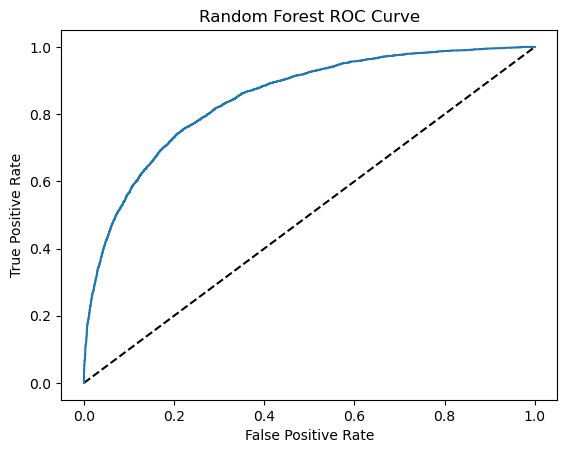

In [74]:
# Fit on training
t0 = time.time()
classifier_rf.fit(X_train, y_train)
ttt = time.time() - t0 # ttt stands for "time to train"
print("It takes %.3f seconds for %s fitting" % (ttt, 'Random Forest'))

# Predict on test
y_pred = classifier_rf.predict(X_test)

# Scoring

print("Accuracy with " + 'Random Forest' + " on the testing set is: %.3f" % classifier_rf.score(X_test, y_test))

y_pred_prob = classifier_rf.predict_proba(X_test)[:,1]
print("ROC AUC score is: %.3f" %roc_auc_score(y_test, y_pred_prob))

print(Conf_Matrix(confusion_matrix(y_test, y_pred)))
print(classification_report(y_test, y_pred))

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('%s ROC Curve' % 'Random Forest')
plt.show()

In [75]:
pd.DataFrame(classifier_rf.feature_importances_,
            index = X_train.columns, columns = ['importance']).sort_values('importance', ascending = False)

,importance
weekday_pct,0.137423
avg_rating_by_driver,0.135637
avg_dist,0.105063
surge_pct,0.101651
city_King's Landing,0.084962
signup_date,0.072066
trips_in_first_30_days,0.070983
avg_surge,0.070460
avg_rating_of_driver,0.049284
ultimate_black_user,0.048415


From here we see that the top 3 features in terms of importance are the percent of the user's trips occurring during a weekday, the rider's average rating over all of their trips, and the average distance in miles per trip taken in the first 30 days after signup.

In [77]:
print(df['weekday_pct'].corr(df['was_retained']))
print(df['avg_rating_by_driver'].corr(df['was_retained']))
print(df['avg_dist'].corr(df['was_retained']))

0.009692972843291937
-0.026748042806069867
-0.09277986324064347


We see that these features are not very correlated with whether or not a user was retained. Let's plot these features and their relationship with whether or not a user was retained to see if we can glean any insight from them.

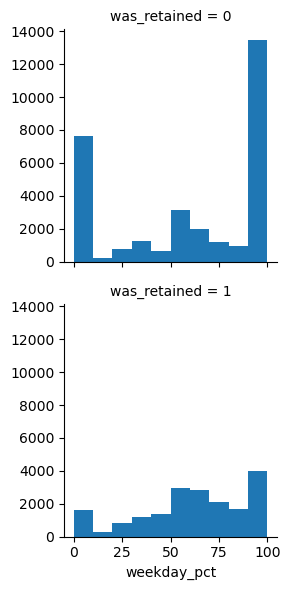

In [80]:
fg = sns.FacetGrid(df, row = 'was_retained')
fg = fg.map(plt.hist, "weekday_pct")

For retained users, it appear as though there was not much of a difference between whether a user booked a ride during a weekday or during the weekend. However, with non-retained users, it seems as though many of them either only booked a ride on the weekdays or exclusively on the weekends. The actionable insight for Ultimate would be to target those users who experience no difference in their need for transportation either during the week or on the weekend. These users are the most retained. 

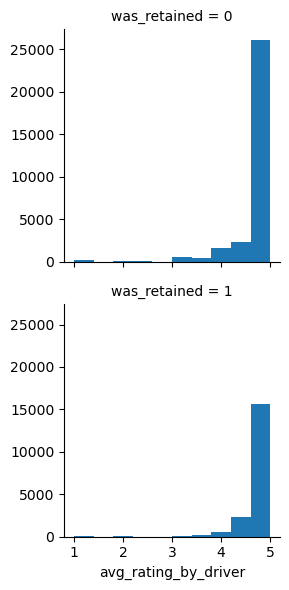

In [81]:
fg = sns.FacetGrid(df, row = 'was_retained')
fg = fg.map(plt.hist, "avg_rating_by_driver")

There are no significant differences in the distribution between these two factors.

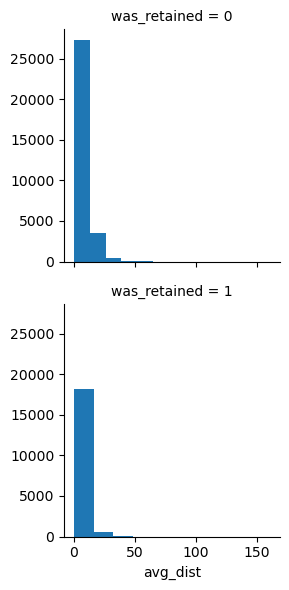

In [82]:
fg = sns.FacetGrid(df, row = 'was_retained')
fg = fg.map(plt.hist, "avg_dist")

Similary to what we saw with `avg_rating_by_driver`, there are no significant differences in the distribution between these two factors.